In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
!pip install timm
!pip3 intsall h5py
import numpy as np

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10 as MegaDepth
%matplotlib inline
from tqdm.auto import tqdm
from torch.utils.data import Dataset
import torch.utils.data as data_utils
model_type = "DPT_Large"

midas = torch.hub.load("intel-isl/MiDaS", model_type)
from torchvision.io import read_image, ImageReadMode
import cv2
import urllib.request

plt.rcParams["figure.figsize"] = (10,10)
torch.manual_seed(0) 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 5.2 MB/s eta 0:00:00a 0:00:01
ERROR: unknown command "intsall" - maybe you meant "install"


Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [3]:
def show_tensor_images(image_tensor, num_images = 80 , size = (3,64,64)):
    
    image_tensor = ( image_tensor + 1 ) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrows= 10)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

In [4]:
class Encoder(nn.Module):

    def __init__(self, im_ch = 3, hidden_dim = 2):
        super().__init__()
        self.encoder = nn.Sequential(
            self.encoder_block(im_ch, hidden_dim*12),
            self.encoder_block(hidden_dim*12, hidden_dim *10, stride = 2),
            self.encoder_block(hidden_dim *10, hidden_dim *8),
            self.encoder_block(hidden_dim *8, hidden_dim *8, stride = 2),
            self.encoder_block(hidden_dim *8, hidden_dim *7),
            self.encoder_block(hidden_dim *7, hidden_dim *4, stride = 2),
            self.encoder_block(hidden_dim *4, hidden_dim *2),
            self.encoder_block(hidden_dim *2, hidden_dim *2),
            self.encoder_block(hidden_dim *2, hidden_dim *1, stride = 2),
            self.encoder_block(hidden_dim *1, hidden_dim *1),
            self.encoder_block(hidden_dim *1, hidden_dim//2),
            )

    def encoder_block(self, in_ch, op_ch, kernel_size = 3, stride = 1, padding = 1, final_layer = False):
        return nn.Sequential(
            nn.Conv2d(in_ch, op_ch, kernel_size, stride, padding),
            nn.InstanceNorm2d(op_ch, affine=True),
            nn.LeakyReLU(0.01, inplace = True),
            )

    def forward(self, image):
        latent = self.encoder(image)
        latent = latent.view(len(latent), -1)
        return latent

In [8]:
random_image_matrix = torch.rand(2, 3, 128, 128)
enc_net = Encoder()
enc_latent = enc_net(random_image_matrix)
enc_latent.shape

torch.Size([2, 64])

In [9]:
class Decoder(nn.Module):
    def __init__(self, z_dim = 64, hidden_dim = 128,):
        super().__init__()
        self.z_dim = z_dim   
        self.decoder = nn.Sequential(
            self.decoder_block(z_dim, hidden_dim, 
                                        kernel_size = 3, stride = 1),
            self.decoder_block(hidden_dim, hidden_dim//2 ,
                                        kernel_size = 3, stride = 1),
            self.decoder_block(hidden_dim//2, hidden_dim//2 ,
                                        kernel_size = 3, stride = 1),
            self.decoder_block(hidden_dim//2 , hidden_dim//4,
                                        kernel_size = 4, stride = 2),
            self.decoder_block(hidden_dim//4 , hidden_dim//8,
                                        kernel_size = 3, stride = 2),
            self.decoder_block(hidden_dim//8 , hidden_dim//16,
                                        kernel_size = 3, stride = 2),
            self.decoder_block(hidden_dim//16 , hidden_dim//32,
                                        kernel_size = 3, stride = 2),
            nn.Conv2d(hidden_dim//32, hidden_dim//32, kernel_size = 5, stride = 1 ),
            nn.Conv2d(hidden_dim//32, 3, kernel_size = 4, stride = 1 )
        )
    def decoder_block(self, in_ch, op_ch, kernel_size, stride, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.InstanceNorm2d(op_ch, affine=True),
                nn.LeakyReLU(0.01, inplace = True), # hyperparameter
                )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.LeakyReLU(0.01, inplace = True), # hyperparameter
            )

    def forward(self, latent):   
        x = latent
        decoder_image = self.decoder(x)
        return decoder_image

In [10]:
dec_net = Decoder()
enc_latent = enc_latent.view(len(enc_latent), 64, 1, 1)
dec_image = dec_net(enc_latent)
dec_image.shape

torch.Size([2, 3, 128, 128])

In [26]:
class DepthNet(nn.Module):

    def __init__(self, im_ch = 3):
        super().__init__()
        self.im_ch = im_ch
        self.Encoder = Encoder()
        self.Decoder = Decoder()

    def forward(self, image):
        latent = self.Encoder(image)
        latent = latent.view(len(latent), 64, 1, 1)
        segmented_depth = self.Decoder(latent)

        return segmented_depth

In [27]:
depthnet = DepthNet()
image = torch.rand(2, 3, 128, 128)
segmented_depth = depthnet(image)
segmented_depth.shape

torch.Size([2, 3, 128, 128])

In [13]:
depthnet.eval()

DepthNet(
  (Encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(24, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(20, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(16, eps=1e-05, mo

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval() 

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0

In [15]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [16]:
import torch.optim as optim

criterion = torch.nn.L1Loss()
optimizer = optim.RMSprop(depthnet.parameters(), lr=0.001, momentum=0.9)

In [17]:
## image depths
import h5py
distances = h5py.File('/kaggle/input/megadepth-v1-p1/MegaDepth_v1_p1/0000/dense1/depths/1000557903_87fa96b8a4_o.h5', 'r')
print(list(distances.keys()))
distances['depth']

['depth']


<HDF5 dataset "depth": shape (949, 1280), type "<f4">

In [18]:
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = MegaDepth(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
# training loop
loss_list = []
for epoch in range(250):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        images, actual_depths = data

        
        optimizer.zero_grad()
        
        depths = depthnet(images)
        shift_scale = 1/(2 *(torch.mean(images)))
        loss = criterion(depths, actual_depths) *  shift_scale
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    loss_list.append(running_loss)

print('Finished Training')

In [19]:
img_addr = "https://i.ytimg.com/vi/NyLF8nHIquM/maxresdefault.jpg"

In [28]:
url, filename = (img_addr, "match.jpg")
urllib.request.urlretrieve(url, filename)

('match.jpg', <http.client.HTTPMessage at 0x7f603466a390>)

In [21]:
## while Testing
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

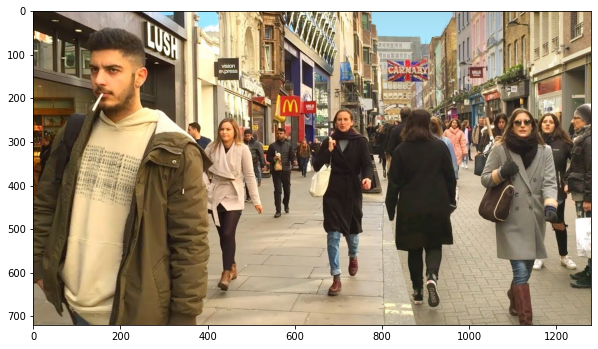

In [25]:
plt.imshow(img)

In [23]:
## while Testing
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

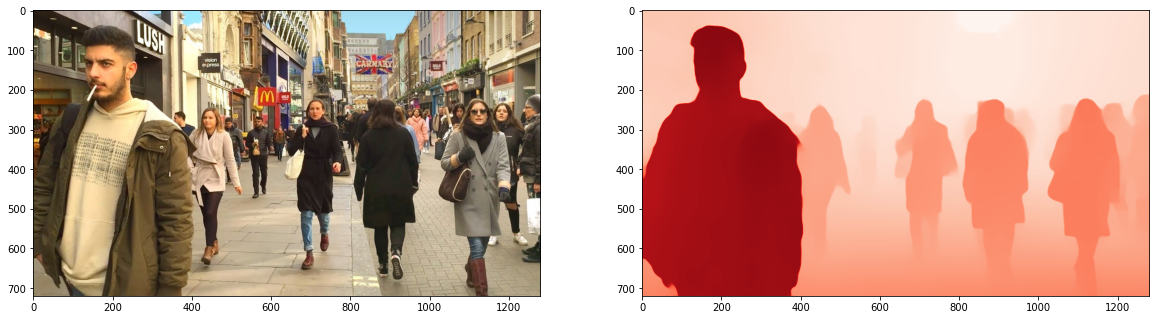

In [24]:
f = plt.figure(figsize=(20,20))
f.add_subplot(1,2, 2)
plt.imshow(output, cmap="Reds")
f.add_subplot(1,2, 1)
plt.imshow(img)
plt.show(block=True)